# Model Notebook

In this notebook we will be using predictive classification models to understand important features of steam games that have more than 1 million users.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math as m
from ast import literal_eval
import itertools
import re
import time


from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from numpy import array 

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             auc,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss)
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
                             
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
                             
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost as xgb
from xgboost import plot_importance

In [2]:
df = pd.read_csv('data/steam_preprocessed.csv')

In [3]:
df

,type,name,appid,required_age,detailed_description,about_the_game,short_description,linux_requirements,platforms,release_date,...,windows,Adult Age,All Ages,Mature Age,Teen Age,Young Teen Age,Cheap,Expensive,Free,Midrange
0,game,Counter-Strike,10,All Ages,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",windows;mac;linux,2000-11-01,...,1,0,1,0,0,0,0,0,0,1
1,game,Team Fortress Classic,20,All Ages,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",windows;mac;linux,1999-04-01,...,1,0,1,0,0,0,1,0,0,0
2,game,Day of Defeat,30,All Ages,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",windows;mac;linux,2003-05-01,...,1,0,1,0,0,0,1,0,0,0
3,game,Deathmatch Classic,40,All Ages,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",windows;mac;linux,2001-06-01,...,1,0,1,0,0,0,1,0,0,0
4,game,Half-Life: Opposing Force,50,All Ages,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",windows;mac;linux,1999-11-01,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,game,Do Something,1810240,All Ages,You buy a game that you can pass to the end. F...,You buy a game that you can pass to the end. F...,"After a few hours of epidemic, you go straight...",{'minimum': '<strong>Minimum:</strong><br><ul ...,windows,2021-12-15,...,1,0,1,0,0,0,0,0,1,0
5485,game,Deadly Racing Duel,1842410,All Ages,Test your driving skills in this unusual racin...,Test your driving skills in this unusual racin...,Deadly Racing Duel - in the role of a racer wh...,[],windows,2022-01-31,...,1,0,1,0,0,0,0,0,0,1
5486,game,Dungeon Crawler,1873960,All Ages,"<img src=""https://cdn.akamai.steamstatic.com/s...","<img src=""https://cdn.akamai.steamstatic.com/s...","Dungeon Crawler is a round-based, third-person...",{'minimum': '<strong>Minimum:</strong><br><ul ...,windows,2022-02-25,...,1,0,1,0,0,0,1,0,0,0
5487,game,AI Roguelite,1889620,All Ages,<strong>ATTENTION: This game requires an NVIDI...,<strong>ATTENTION: This game requires an NVIDI...,"Infinite text-based RPG, powered by cutting-ed...",[],windows,2022-03-02,...,1,0,1,0,0,0,1,0,0,0


In [4]:
def drop_cols(df, cols):
    """ Drop unnecessary columns """
    df = df.copy()
    
    df.drop(columns = cols, axis = 0, inplace = True)
    
    return df

model_df = drop_cols(df, cols = ['type','name','appid','platforms','release_date','developer','publisher','positive_ratings',
                            'negative_ratings','owners','average_playtime','median_playtime','initialprice','languages',
                            'ccu','owners_min','total_owners','pc_minimum','pc_recommended','mac_minimum',
                            'mac_recommended','linux_minimum','linux_recommend','price_range','total_ratings', 
                            'detailed_description','about_the_game','short_description','linux_requirements',
                            'game_attributes', 'required_age', 'price', 'review_score', 'min_revenue'])

In [5]:
model_df

,discount,rating,multiplayer,singleplayer,release_year,max_revenue,over_1mil,Singleplayer,Indie,Steam_Achievements,...,windows,Adult Age,All Ages,Mature Age,Teen Age,Young Teen Age,Cheap,Expensive,Free,Midrange
0,0,96.0,1,0,2000,199800000.0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,0,83.0,1,0,1999,49900000.0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,87.0,1,0,2003,49900000.0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,0,79.0,1,0,2001,49900000.0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0,92.0,1,1,1999,49900000.0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,0,40.0,0,1,2021,0.0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
5485,0,71.0,0,1,2022,2198000.0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,1
5486,0,56.0,0,1,2022,1198000.0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
5487,0,58.0,0,1,2022,998000.0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0


In [6]:
model_df.shape

(5489, 280)

## Multicollinearity

In [7]:
num = ['discount','release_year', 'rating', 'max_revenue']
cat = [col for col in model_df.columns if col not in num]
cat_feats = model_df[cat]

In [8]:
# Features will be the x value
X = pd.concat([model_df[num], model_df[cat].drop('over_1mil', axis=1)],axis=1)
y = model_df.over_1mil
print(X.shape, y.shape)

(5489, 279) (5489,)


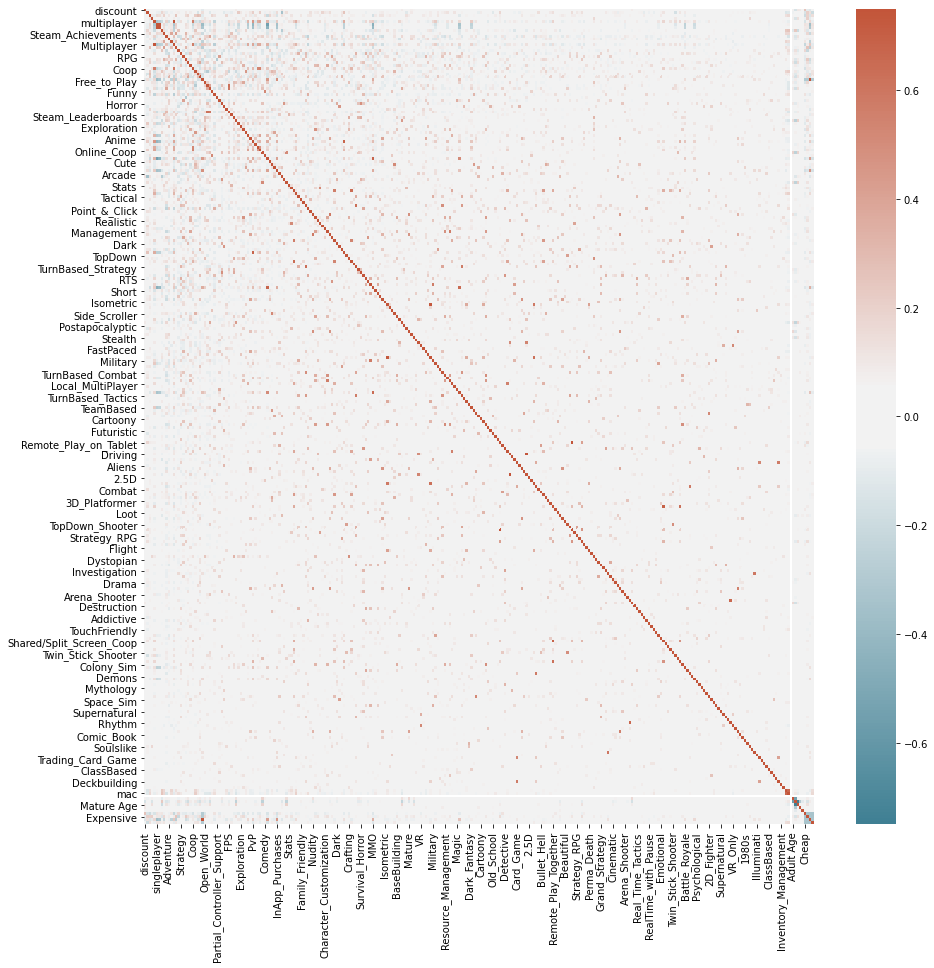

In [9]:
def heatmap(data,figsize=(8,8), annot=False):
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);
    
heatmap(X, figsize=(15,15))

Since we have over 200 features to work with, it's not easy to decipher which features have multicollinearity so we'll have the code below show us the correlated columns. 

In [10]:
TARGET = '1mil'
FEATURES = [col for col in model_df.columns if col not in TARGET]

high_corr=model_df[FEATURES].corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
high_corr['pairs'] = list(zip(high_corr.level_0, high_corr.level_1))

# set index to pairs
high_corr.set_index(['pairs'], inplace = True)

#drop level columns
high_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
high_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
high_corr.drop_duplicates(inplace=True)

print(high_corr[(high_corr.cc>.65) & (high_corr.cc <1)][(high_corr.cc>.65) & (high_corr.cc <1)])

                                                        cc
pairs                                                     
(Free, Free_to_Play)                              0.885077
(Remote_Play_on_Tablet, Remote_Play_on_Phone)     0.832883
(singleplayer, Singleplayer)                      0.830252
(Driving, Automobile_Sim)                         0.764340
(multiplayer, Multiplayer)                        0.751081
(Mature Age, All Ages)                            0.740030
(Roguelite, Roguelike)                            0.728498
(Shared/Split_Screen_Coop, Remote_Play_Together)  0.695978
(MMO, Massively_Multiplayer)                      0.682459
(PvP, Online_PvP)                                 0.681690
(mac, linux)                                      0.664912
(Rhythm, Music)                                   0.659519
(MMORPG, MMO)                                     0.653642


In [11]:
# drop the highly correlated features
model_df = drop_cols(model_df, cols = ['Free_to_Play', 'Remote_Play_on_Phone', 'singleplayer', 'Driving', 
                                       'multiplayer','Roguelite', 'Shared/Split_Screen_Coop', 'MMO', 
                                       'Online_PvP', 'Music', 'Mature Age', 'linux'])

Upon taking a closer look at the correlated columns, we dropped the features that were either a duplicated tag that our dummy labels did not pick up on or keep one feature and drop the other features that are too vague for suggestions.

## Selected Features

In [12]:
# Reset the features with the dropped multicolinearity features
num = ['discount','release_year', 'rating', 'max_revenue']
cat = [col for col in model_df.columns if col not in num]
cat_feats = model_df[cat]
X = pd.concat([model_df[num], model_df[cat].drop('over_1mil', axis=1)],axis=1)
y = model_df.over_1mil
print(X.shape, y.shape)

(5489, 267) (5489,)


## Test Train Split

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.head()

,discount,release_year,rating,max_revenue,Singleplayer,Indie,Steam_Achievements,Action,Adventure,Steam_Trading_Cards,...,mac,windows,Adult Age,All Ages,Teen Age,Young Teen Age,Cheap,Expensive,Free,Midrange
3245,0,2017,91.0,0.0,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,1,0
5354,0,2020,87.0,0.0,1,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2339,0,2015,90.0,24950000.0,1,1,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0
1465,0,2015,72.0,3495000.0,1,1,1,1,0,1,...,1,1,0,1,0,0,1,0,0,0
1295,0,2015,88.0,7495000.0,1,1,1,1,1,0,...,0,1,0,1,0,0,0,0,0,1


In [14]:
def get_model(model):
    """ Take the model instantiated model and display the model visual classification/confusion matrix """
    #Fit model
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Get classification report
    target_names =  ['< 1mil users', '>=1milusers']
    print('              Classification Report for Training Set')
    print(classification_report(y_train, y_pred_train, target_names = target_names))
    print('              Classification Report for Test Set')
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    # Plot confusion Matrix
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
    plot_confusion_matrix(model, X_train, y_train,
                     cmap=plt.cm.Blues, ax=ax0, 
                      display_labels = target_names, normalize = 'all')
    plot_confusion_matrix(model, X_test, y_test,
                     cmap=plt.cm.Blues, ax=ax1,
                     display_labels = target_names, normalize = 'all')

    ax0.set(title = 'Train Confusion Matrix')
    ax1.set(title = 'Test Confusion Matrix')
    ax0.grid(False)
    ax1.grid(False)
    plt.show()
    
    return model

def tuned_metrics(model):
    
    # Get predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Get classification report
    target_names =  ['< 1mil users', '>=1milusers']
    print(f'              Classification Report for Training Set')
    print(classification_report(y_train, y_pred_train, target_names = target_names))
    print(f'              Classification Report for Test Set ')
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    # Plot confusion Matrix
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
    plot_confusion_matrix(model, X_train, y_train,
                     cmap=plt.cm.Blues, ax=ax0, 
                      display_labels = target_names, normalize = 'all')
    plot_confusion_matrix(model, X_test, y_test,
                     cmap=plt.cm.Blues, ax=ax1,
                     display_labels = target_names, normalize = 'all')

    ax0.set(title = f'Train Confusion Matrix')
    ax1.set(title = f'Test Confusion Matrix')
    ax0.grid(False)
    ax1.grid(False)
    plt.show()
    
    return model

def get_roc(model):
    """ Display ROC curve to show how well the model distinguishes the positive and negative values """
    # Calculate the probability scores of each point in the training set
    y_train_score = model.decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = model.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    # plotting ROC curve
    plt.subplots(figsize = (10,7))

    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    # training set
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Training Set')
    plt.legend(loc='lower right')
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    plt.show()
    
    # ROC curve for test set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
    plt.legend(loc='lower right')
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('')
    plt.show()
    
def get_auc(model):
    y_pred = model.predict(X_test)

    # Check the AUC of predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

## Simple Baseline Models

In [15]:
def baseline_models(data=[], verbose=False):
    # List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(fit_intercept = False),
            RandomForestClassifier(),GradientBoostingClassifier(), KNeighborsClassifier()]
    
    # Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    
    # Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, y_pred_test))
        accuracy.append(accuracy_score(y_test, y_pred_test))
        auc.append(roc_auc_score(y_test, y_pred_test))
        recall.append(recall_score(y_test, y_pred_test))
        precision.append(precision_score(y_test, y_pred_test))
        #Print the model and its report
        if verbose:
            target_names =  ['<1mil users', '>=1milusers']
            print('Classification Model for:',model,'Train Set')
            print(classification_report(y_train, y_pred_train, target_names = target_names))
            print('Classification Model for:',model, 'Test Set ')
            print(classification_report(y_test, y_pred_test, target_names = target_names))
            
            # Plot confusion Matrix
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
            plot_confusion_matrix(model, X_train, y_train,
                             cmap=plt.cm.Blues, ax=ax0, 
                              display_labels = target_names, normalize = 'all')
            plot_confusion_matrix(model, X_test, y_test,
                             cmap=plt.cm.Blues, ax=ax1,
                             display_labels = target_names, normalize = 'all')

            ax0.set(title = f'Train Confusion Matrix')
            ax1.set(title = f'Test Confusion Matrix')
            ax0.grid(False)
            ax1.grid(False)
            plt.show()
    
            
    # store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting', 'KNN'])
    
    #Change orientation of the dataframe
    return results.transpose()

Classification Model for: DecisionTreeClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2932
 >=1milusers       1.00      1.00      1.00      1184

    accuracy                           1.00      4116
   macro avg       1.00      1.00      1.00      4116
weighted avg       1.00      1.00      1.00      4116

Classification Model for: DecisionTreeClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.94      0.94      0.94      1000
 >=1milusers       0.84      0.83      0.83       373

    accuracy                           0.91      1373
   macro avg       0.89      0.89      0.89      1373
weighted avg       0.91      0.91      0.91      1373



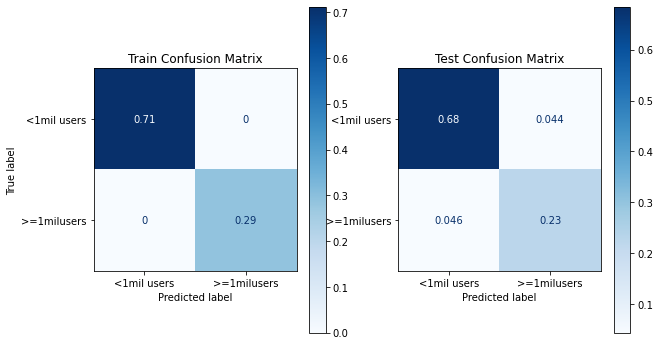

Classification Model for: LogisticRegression(fit_intercept=False) Train Set
              precision    recall  f1-score   support

 <1mil users       0.82      0.98      0.89      2932
 >=1milusers       0.92      0.47      0.62      1184

    accuracy                           0.83      4116
   macro avg       0.87      0.73      0.76      4116
weighted avg       0.85      0.83      0.82      4116

Classification Model for: LogisticRegression(fit_intercept=False) Test Set 
              precision    recall  f1-score   support

 <1mil users       0.84      0.98      0.90      1000
 >=1milusers       0.89      0.49      0.63       373

    accuracy                           0.84      1373
   macro avg       0.86      0.73      0.77      1373
weighted avg       0.85      0.84      0.83      1373



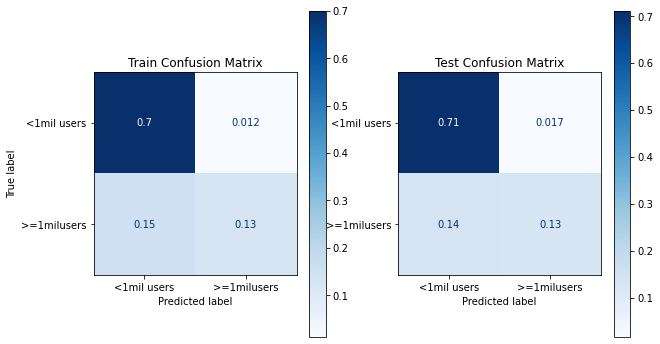

Classification Model for: RandomForestClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2932
 >=1milusers       1.00      1.00      1.00      1184

    accuracy                           1.00      4116
   macro avg       1.00      1.00      1.00      4116
weighted avg       1.00      1.00      1.00      4116

Classification Model for: RandomForestClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.89      0.97      0.93      1000
 >=1milusers       0.89      0.67      0.77       373

    accuracy                           0.89      1373
   macro avg       0.89      0.82      0.85      1373
weighted avg       0.89      0.89      0.88      1373



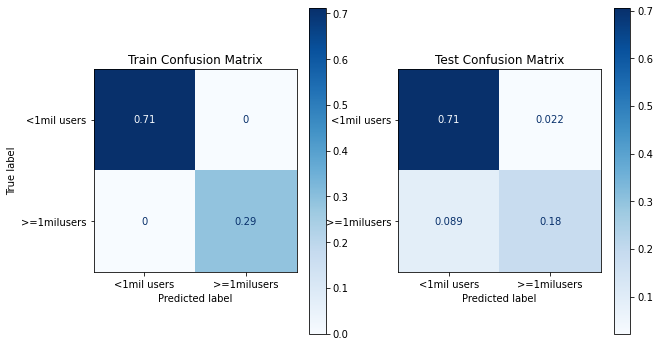

Classification Model for: GradientBoostingClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.94      0.99      0.96      2932
 >=1milusers       0.98      0.84      0.90      1184

    accuracy                           0.95      4116
   macro avg       0.96      0.92      0.93      4116
weighted avg       0.95      0.95      0.95      4116

Classification Model for: GradientBoostingClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.92      0.97      0.95      1000
 >=1milusers       0.92      0.78      0.84       373

    accuracy                           0.92      1373
   macro avg       0.92      0.88      0.90      1373
weighted avg       0.92      0.92      0.92      1373



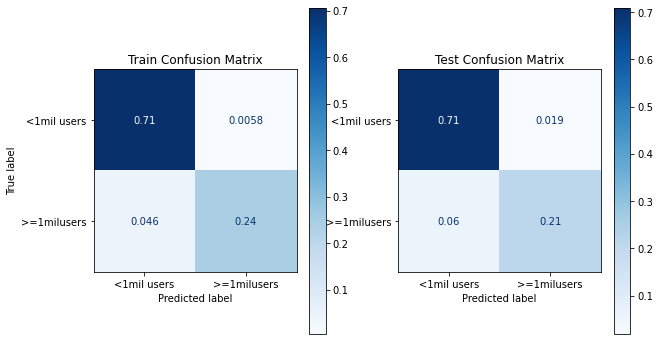

Classification Model for: KNeighborsClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.93      0.99      0.96      2932
 >=1milusers       0.98      0.81      0.89      1184

    accuracy                           0.94      4116
   macro avg       0.95      0.90      0.92      4116
weighted avg       0.94      0.94      0.94      4116

Classification Model for: KNeighborsClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.92      0.99      0.95      1000
 >=1milusers       0.97      0.76      0.85       373

    accuracy                           0.93      1373
   macro avg       0.94      0.87      0.90      1373
weighted avg       0.93      0.93      0.92      1373



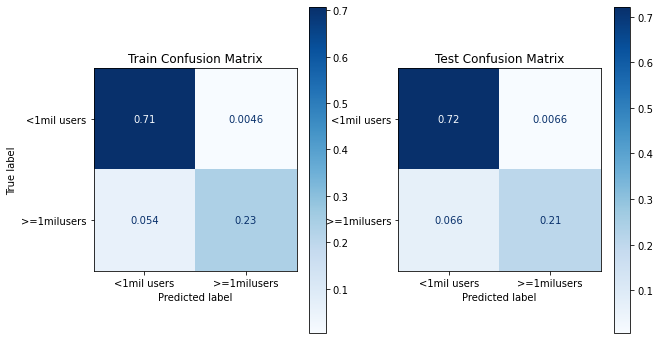

In [16]:
results1 = baseline_models(data=[X,y], verbose=True)

In [17]:
results1.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
KNN,0.849398,0.873516,0.927167,0.969072,0.756032
Gradient Boosting,0.843478,0.877080,0.921340,0.917981,0.780161
DecisionTree,0.834455,0.885550,0.910415,0.837838,0.831099
RandomForest,0.767584,0.821461,0.889294,0.893238,0.672922
LogisticRegression,0.629758,0.732468,0.844137,0.887805,0.487936


In [18]:
print('Best Model per Metric')
for metric in results1.columns:
    print(f'{metric.capitalize()}:',results1.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: KNN
Roc_auc: DecisionTree
Accuracy: KNN
Precision: KNN
Recall: DecisionTree


Baseline Vanilla Classification Model Results:

Many of our models performed extremely well on their training data but a little lower than the test set. You can see a difference in scores for Decision Tree and Random Forest with a testing set f1-score of .83 and .77 respectively. Models that follow this pattern exhibit signs of overfitting. In order to prevent our models from creating bias we need to perform scaling and SMOTENC to correct for the imbalance targets.

## Scaling

In [19]:
'''Scaling the data first fitting it and transforming the training set
to later aply the fit to transform the test set.'''
#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(X_train[num]), 
                                     columns=num, index= X_train.index)
#Integrate scaled values to the training set
for col in num:
    X_train[col] = scaled_numfeats_train[col]
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(X_test[num]),
                                    columns=num, index= X_test.index)
#Integrate scaled values to the test set
for col in num:
    X_test[col] = scaled_numfeats_test[col]

Classification Model for: DecisionTreeClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2949
 >=1milusers       1.00      1.00      1.00      1167

    accuracy                           1.00      4116
   macro avg       1.00      1.00      1.00      4116
weighted avg       1.00      1.00      1.00      4116

Classification Model for: DecisionTreeClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.94      0.96      0.95       983
 >=1milusers       0.88      0.84      0.86       390

    accuracy                           0.92      1373
   macro avg       0.91      0.90      0.90      1373
weighted avg       0.92      0.92      0.92      1373



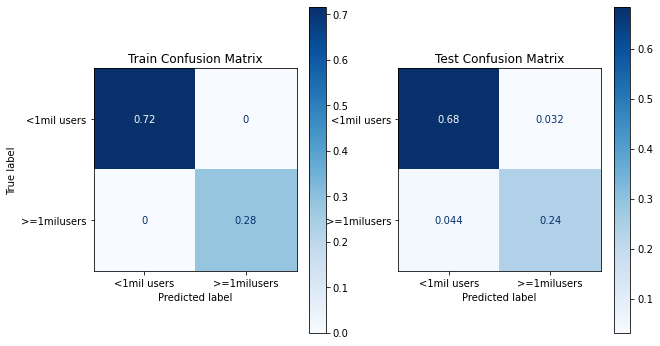

Classification Model for: LogisticRegression(fit_intercept=False) Train Set
              precision    recall  f1-score   support

 <1mil users       0.91      0.98      0.94      2949
 >=1milusers       0.93      0.75      0.83      1167

    accuracy                           0.91      4116
   macro avg       0.92      0.86      0.88      4116
weighted avg       0.91      0.91      0.91      4116

Classification Model for: LogisticRegression(fit_intercept=False) Test Set 
              precision    recall  f1-score   support

 <1mil users       0.89      0.96      0.92       983
 >=1milusers       0.86      0.71      0.78       390

    accuracy                           0.88      1373
   macro avg       0.88      0.83      0.85      1373
weighted avg       0.88      0.88      0.88      1373



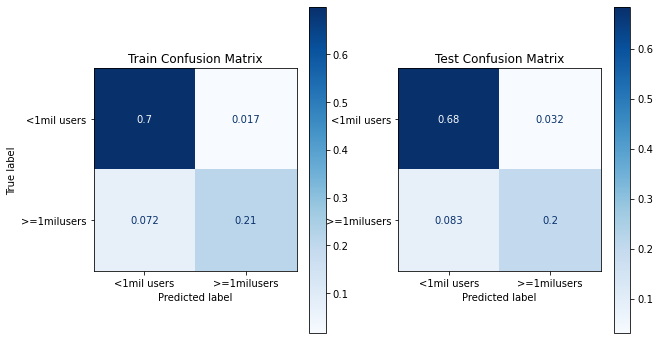

Classification Model for: RandomForestClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2949
 >=1milusers       1.00      1.00      1.00      1167

    accuracy                           1.00      4116
   macro avg       1.00      1.00      1.00      4116
weighted avg       1.00      1.00      1.00      4116

Classification Model for: RandomForestClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.87      0.98      0.92       983
 >=1milusers       0.93      0.62      0.74       390

    accuracy                           0.88      1373
   macro avg       0.90      0.80      0.83      1373
weighted avg       0.88      0.88      0.87      1373



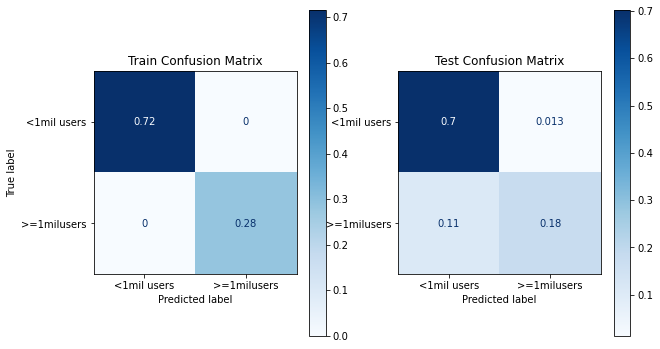

Classification Model for: GradientBoostingClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.94      0.99      0.97      2949
 >=1milusers       0.98      0.85      0.91      1167

    accuracy                           0.95      4116
   macro avg       0.96      0.92      0.94      4116
weighted avg       0.95      0.95      0.95      4116

Classification Model for: GradientBoostingClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.92      0.98      0.95       983
 >=1milusers       0.94      0.78      0.85       390

    accuracy                           0.92      1373
   macro avg       0.93      0.88      0.90      1373
weighted avg       0.92      0.92      0.92      1373



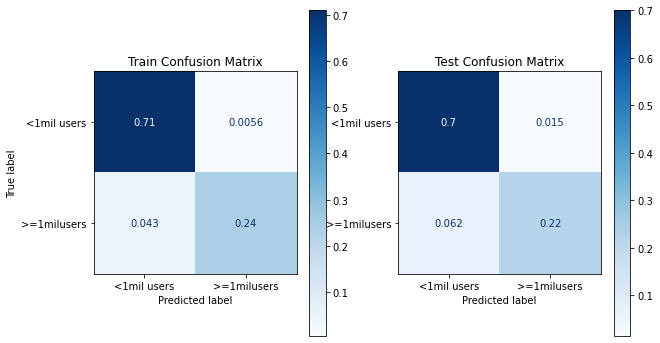

Classification Model for: KNeighborsClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.82      0.98      0.90      2949
 >=1milusers       0.91      0.47      0.62      1167

    accuracy                           0.84      4116
   macro avg       0.86      0.73      0.76      4116
weighted avg       0.85      0.84      0.82      4116

Classification Model for: KNeighborsClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.79      0.97      0.87       983
 >=1milusers       0.80      0.34      0.48       390

    accuracy                           0.79      1373
   macro avg       0.80      0.65      0.67      1373
weighted avg       0.79      0.79      0.76      1373



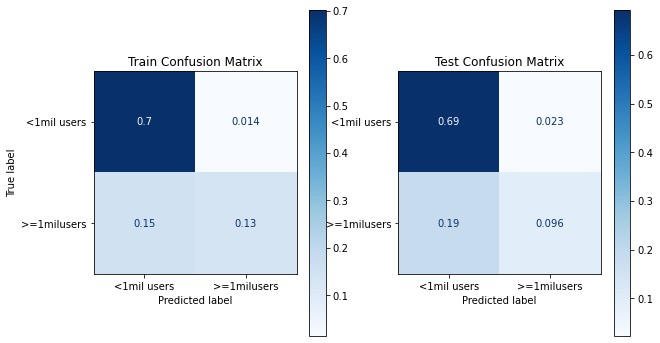

,f1,roc_auc,accuracy,precision,recall
DecisionTree,0.862385,0.899414,0.923525,0.882038,0.843590
Gradient Boosting,0.853147,0.880853,0.923525,0.938462,0.782051
LogisticRegression,0.777465,0.831466,0.884924,0.862500,0.707692
RandomForest,0.742681,0.799819,0.878369,0.930502,0.617949
KNN,0.476534,0.652954,0.788784,0.804878,0.338462


In [20]:
results2 = baseline_models(data=[X_train, X_test, y_train, y_test], verbose = True)
results2.sort_values('f1',ascending=False)

In [21]:
print('Best Model per Metric')
for metric in results2.columns:
    print(f'{metric.capitalize()}:', results2.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: DecisionTree
Roc_auc: DecisionTree
Accuracy: DecisionTree
Precision: Gradient Boosting
Recall: DecisionTree


Some of the models here performed well after scaling the numerical features. Except for KNeighbors. So far the models seem to favor the true negatives vs. the true positives. Still showing some slight overfitting.

## Over Sampling with Smote after Scaling

Since our data has class imbalance our next method is to use SMOTENC. SMOTENC will slightly change the way a new sample is generated by performing new generated sample from the specified categorical features.

0    71.63
1    28.37
Name: over_1mil, dtype: float64


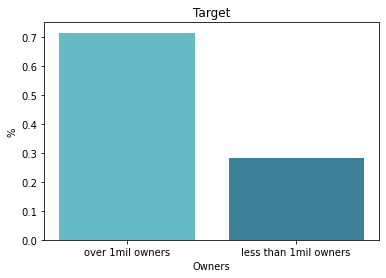

In [22]:
print(round(model_df.over_1mil.value_counts(normalize=True),4)*100)
plt.bar(['over 1mil owners','less than 1mil owners'], model_df.over_1mil.value_counts(normalize=True), color=sns.color_palette("GnBu_d",n_colors=2))
plt.title('Target')
plt.ylabel('%')
plt.xlabel('Owners')
plt.show();

Smote-NC can be used by denoting the features that are categorical, and Smote would resample the categorical data instead of creating synthetic data.

In [23]:
cat_col_index = list(range(len(num), 266))
sm = SMOTENC(categorical_features=cat_col_index, random_state=123)
X_trainres, y_trainres = sm.fit_resample(X_train,y_train)

In [24]:
y_trainres.value_counts(normalize=True)

1    0.5
0    0.5
Name: over_1mil, dtype: float64

Classification Model for: DecisionTreeClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2949
 >=1milusers       1.00      1.00      1.00      2949

    accuracy                           1.00      5898
   macro avg       1.00      1.00      1.00      5898
weighted avg       1.00      1.00      1.00      5898

Classification Model for: DecisionTreeClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.93      0.91      0.92       983
 >=1milusers       0.78      0.82      0.80       390

    accuracy                           0.88      1373
   macro avg       0.85      0.86      0.86      1373
weighted avg       0.89      0.88      0.88      1373



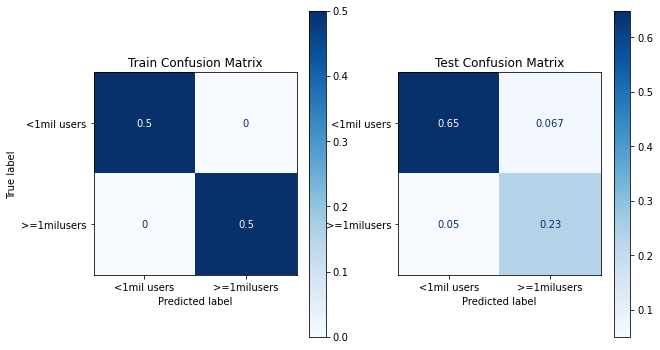

Classification Model for: LogisticRegression(fit_intercept=False) Train Set
              precision    recall  f1-score   support

 <1mil users       0.88      0.93      0.90      2949
 >=1milusers       0.92      0.87      0.90      2949

    accuracy                           0.90      5898
   macro avg       0.90      0.90      0.90      5898
weighted avg       0.90      0.90      0.90      5898

Classification Model for: LogisticRegression(fit_intercept=False) Test Set 
              precision    recall  f1-score   support

 <1mil users       0.90      0.90      0.90       983
 >=1milusers       0.74      0.74      0.74       390

    accuracy                           0.85      1373
   macro avg       0.82      0.82      0.82      1373
weighted avg       0.85      0.85      0.85      1373



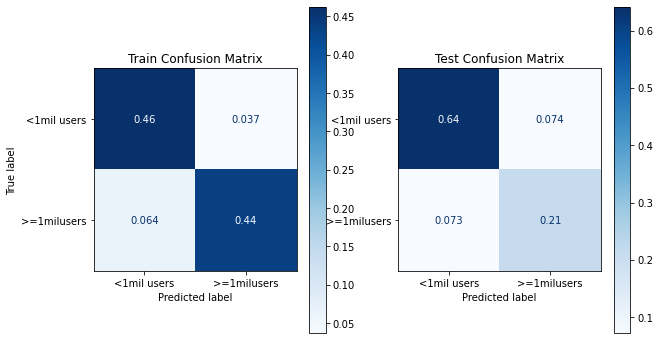

Classification Model for: RandomForestClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       1.00      1.00      1.00      2949
 >=1milusers       1.00      1.00      1.00      2949

    accuracy                           1.00      5898
   macro avg       1.00      1.00      1.00      5898
weighted avg       1.00      1.00      1.00      5898

Classification Model for: RandomForestClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.89      0.95      0.92       983
 >=1milusers       0.84      0.72      0.78       390

    accuracy                           0.88      1373
   macro avg       0.87      0.83      0.85      1373
weighted avg       0.88      0.88      0.88      1373



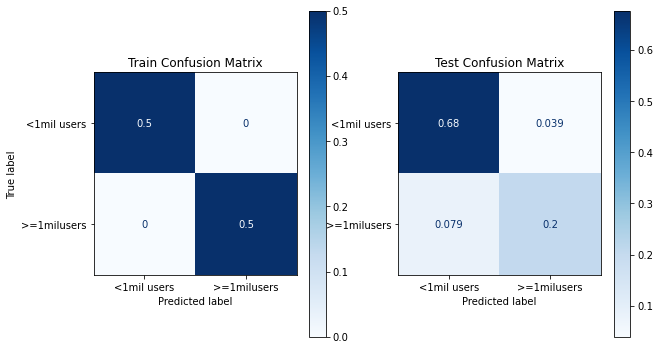

Classification Model for: GradientBoostingClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.91      0.96      0.94      2949
 >=1milusers       0.96      0.91      0.93      2949

    accuracy                           0.94      5898
   macro avg       0.94      0.94      0.94      5898
weighted avg       0.94      0.94      0.94      5898

Classification Model for: GradientBoostingClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.93      0.95      0.94       983
 >=1milusers       0.86      0.82      0.84       390

    accuracy                           0.91      1373
   macro avg       0.90      0.89      0.89      1373
weighted avg       0.91      0.91      0.91      1373



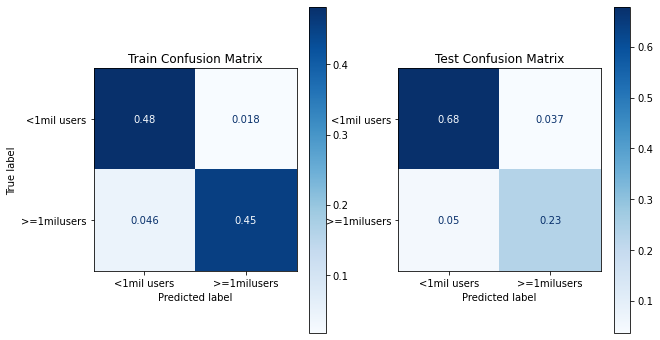

Classification Model for: KNeighborsClassifier() Train Set
              precision    recall  f1-score   support

 <1mil users       0.96      0.60      0.74      2949
 >=1milusers       0.71      0.98      0.82      2949

    accuracy                           0.79      5898
   macro avg       0.84      0.79      0.78      5898
weighted avg       0.84      0.79      0.78      5898

Classification Model for: KNeighborsClassifier() Test Set 
              precision    recall  f1-score   support

 <1mil users       0.88      0.44      0.59       983
 >=1milusers       0.38      0.85      0.52       390

    accuracy                           0.56      1373
   macro avg       0.63      0.64      0.56      1373
weighted avg       0.74      0.56      0.57      1373



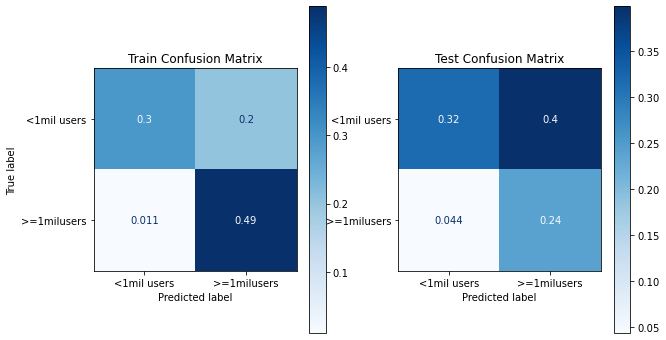

In [25]:
results3 = baseline_models(data=[X_trainres, X_test, y_trainres, y_test], verbose=True)

In [26]:
results3.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.842520,0.885597,0.912600,0.862903,0.823077
DecisionTree,0.799502,0.864743,0.882739,0.777240,0.823077
RandomForest,0.775172,0.832789,0.881282,0.838806,0.720513
LogisticRegression,0.741688,0.819913,0.852877,0.739796,0.743590
KNN,0.520916,0.644847,0.557902,0.376283,0.846154


In [27]:
print('Best Model per Metric')
for metric in results3.columns:
    print(f'{metric.capitalize()}:',results3.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: Gradient Boosting
Roc_auc: Gradient Boosting
Accuracy: Gradient Boosting
Precision: Gradient Boosting
Recall: KNN


It seems like the f1-scores are being affected by SMOTENC. It could possibly be from the oversampling on the 1mil+ target to balance the under 1mil users.


## Baseline Model Results

In [28]:
print(results1.sort_values('f1',ascending=False))
print(results2.sort_values('f1',ascending=False))
print(results3.sort_values('f1',ascending=False))

                          f1   roc_auc  accuracy  precision    recall
KNN                 0.849398  0.873516  0.927167   0.969072  0.756032
Gradient Boosting   0.843478  0.877080  0.921340   0.917981  0.780161
DecisionTree        0.834455  0.885550  0.910415   0.837838  0.831099
RandomForest        0.767584  0.821461  0.889294   0.893238  0.672922
LogisticRegression  0.629758  0.732468  0.844137   0.887805  0.487936
                          f1   roc_auc  accuracy  precision    recall
DecisionTree        0.862385  0.899414  0.923525   0.882038  0.843590
Gradient Boosting   0.853147  0.880853  0.923525   0.938462  0.782051
LogisticRegression  0.777465  0.831466  0.884924   0.862500  0.707692
RandomForest        0.742681  0.799819  0.878369   0.930502  0.617949
KNN                 0.476534  0.652954  0.788784   0.804878  0.338462
                          f1   roc_auc  accuracy  precision    recall
Gradient Boosting   0.842520  0.885597  0.912600   0.862903  0.823077
DecisionTree        

Based on the three baseline models, using scaling and using SMOTE slightly improves our f1 score and our AUC score. 

In [29]:
def plot_feat_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(20)
    feat_importances.plot(kind='barh', title='Top 20 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();

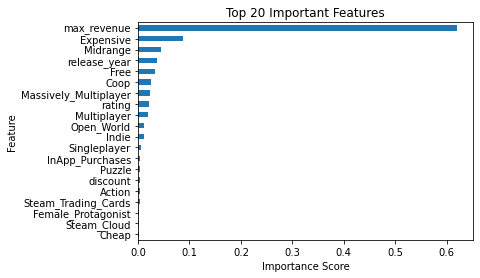

In [30]:
# Feature importance before tuning models
clf = GradientBoostingClassifier()
clf.fit(X_trainres, y_trainres)
plot_feat_importance(clf, X_trainres.columns)

Based on the two baseline models, using SMOTE slightly improves our f1 score and our AUC score. 

Before we start tuning our models, plotting a Principal Component Analysis will help reduce linear dimensionality of the data to help the models process the information better. This will help us find the best n_estimators that repsents the most variance in the data for our tuning parameters.

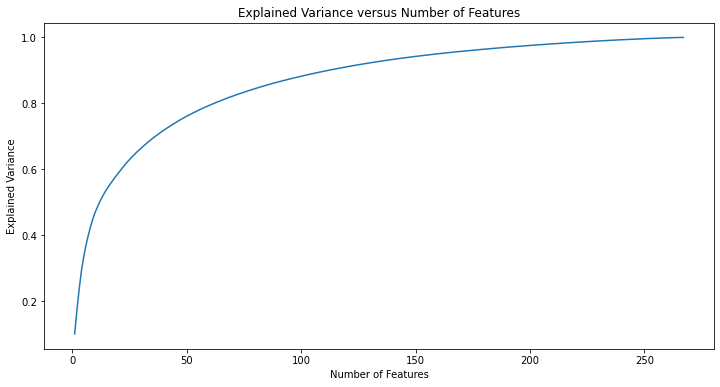

In [31]:
#Instantiate Principal Component Analysis.
pca=PCA()
X_pca = pca.fit_transform(X_trainres)
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,X_trainres.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance versus Number of Features')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Features')
plt.show();

In [32]:
for n in [50,100,150,200, 250]:
    pca_n = PCA(n_components=n)
    X_pcan = pca_n.fit_transform(X_trainres)
    tev = round(np.sum(pca_n.explained_variance_ratio_)*100,2)
    print('Number of Fetaures: ',n, 'Total Explained Variance: ',tev,'%')

Number of Fetaures:  50 Total Explained Variance:  75.99 %
Number of Fetaures:  100 Total Explained Variance:  88.15 %
Number of Fetaures:  150 Total Explained Variance:  94.18 %
Number of Fetaures:  200 Total Explained Variance:  97.52 %
Number of Fetaures:  250 Total Explained Variance:  99.63 %


The variance  rate slowly increases at around n_component 150. It also reduces its dimenionality by ~4% with a ~99% total variable explained

## Pipeline BaseLine Models

In [33]:
def grid_pipe(pipedict, hyperdict, scoring='f1', display=True):
    model_scores=[]
    fitted_models={}
    for name, pipeline in pipedict.items():
    # Construct grid search
        model = GridSearchCV(estimator=pipeline,
                             param_grid=hyperdict[name],
                             scoring=scoring,
                             cv=5, verbose=2, n_jobs=-1, return_train_score = True)

        # Fit using grid search
        start = time.time()
        model.fit(X_trainres, y_trainres)
        end = time.time()
        #Append socres and time
        model_scores.append((name,model.best_score_,end-start))
        #Append model
        fitted_models[name]=model
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best accuracy
            print('Best accuracy: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')
    
    return model_scores, fitted_models

In [34]:
#Create pipeline for each of the classifiers.
pipelines = {'logisticregression': Pipeline([('pca', PCA()),
                                            ('clf', LogisticRegression(random_state=123))]),
            'decisiontree':Pipeline([('pca', PCA()),
                                            ('clf', DecisionTreeClassifier(random_state=123))]),
            'randomforest':Pipeline([('pca', PCA()),
                                            ('clf', RandomForestClassifier(random_state=123))]),
            'gradientboosting': Pipeline([('pca', PCA()),
                                            ('clf', GradientBoostingClassifier(random_state=123))])}

#Define Hyperparameters for each pipeline
hyperparameters_lr ={'pca__n_components': [150,200, 250],
                     'clf__C': [0.01,0.1,1]}

hyperparameters_dt ={'pca__n_components': [150,200, 250],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_rf ={'pca__n_components': [150,200, 250],
                     'clf__n_estimators': [100,150],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_gb ={'pca__n_components': [150,200, 250],
                     'clf__n_estimators': [100,150], 
                     'clf__max_depth': [1, 3, 5],  
                     'clf__learning_rate': [0.05,0.1]}

#Instantiate hyperparapeter dictionary
hyperparameters = {'logisticregression':hyperparameters_lr ,
                   'decisiontree':hyperparameters_dt,
                   'randomforest':hyperparameters_rf,
                   'gradientboosting': hyperparameters_gb}

In [35]:
model_scores_auc, fitted_models_auc = grid_pipe(pipelines,hyperparameters,scoring='roc_auc')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    5.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


The logisticregression model has been fitted.
Best accuracy: 0.929
Best params:
 {'clf__C': 1, 'pca__n_components': 200} 

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   51.7s finished


The decisiontree model has been fitted.
Best accuracy: 0.811
Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'pca__n_components': 150} 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.8min finished


The randomforest model has been fitted.
Best accuracy: 0.852
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.1, 'clf__n_estimators': 100, 'pca__n_components': 150} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.9min finished


The gradientboosting model has been fitted.
Best accuracy: 0.926
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'pca__n_components': 200} 



In [36]:
score_times_df_auc = pd.DataFrame(model_scores_auc,
                              columns=['classifier','roc_auc_score',
                                       'time']).set_index('classifier').sort_values('time')
score_times_df_auc

,roc_auc_score,time
classifier,,
logisticregression,0.928989,5.759934
decisiontree,0.811415,52.386056
randomforest,0.851577,230.930372
gradientboosting,0.925901,414.807427


In [37]:
#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn

def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='k', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, .1]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, .1]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')

In [38]:
def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
    
def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

logisticregression :


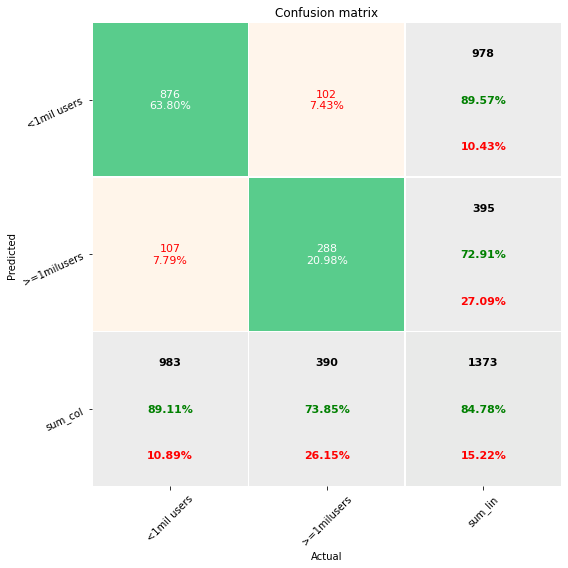

gradientboosting :


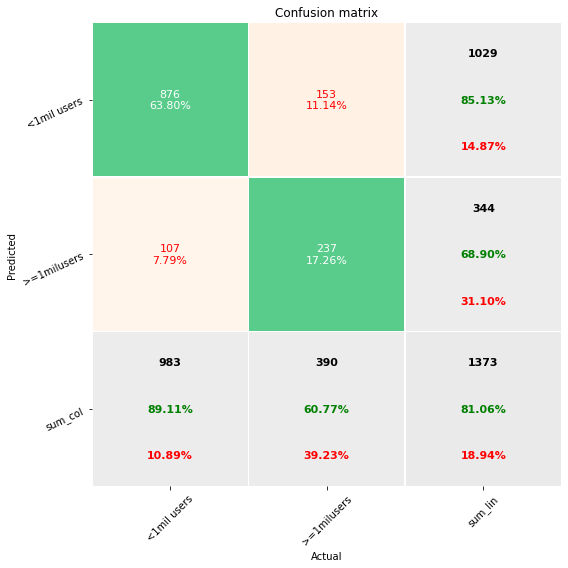

In [39]:
for name, model in fitted_models_auc.items():
    if name in ['logisticregression','gradientboosting']:
        pred = model.predict(X_test)
        print(name,':')
        plot_confusion_matrix_from_data(y_test,pred, columns=['<1mil users', '>=1milusers'], cmap='Oranges')

In [40]:
model_scores_f1, fitted_models_f1 = grid_pipe(pipelines,hyperparameters,scoring='f1')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.1s finished


The logisticregression model has been fitted.
Best accuracy: 0.848
Best params:
 {'clf__C': 1, 'pca__n_components': 250} 

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   51.6s finished


The decisiontree model has been fitted.
Best accuracy: 0.725
Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.1, 'pca__n_components': 200} 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.8min finished


The randomforest model has been fitted.
Best accuracy: 0.742
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 100, 'pca__n_components': 150} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.0min finished


The gradientboosting model has been fitted.
Best accuracy: 0.843
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'pca__n_components': 150} 



In [41]:
score_times_df_f1 = pd.DataFrame(model_scores_f1,
                              columns=['classifier','f1_score',
                                       'time']).set_index('classifier').sort_values('time')
score_times_df_f1

,f1_score,time
classifier,,
logisticregression,0.847674,3.435124
decisiontree,0.724860,52.446834
randomforest,0.741576,232.808772
gradientboosting,0.842897,407.164805


logisticregression :


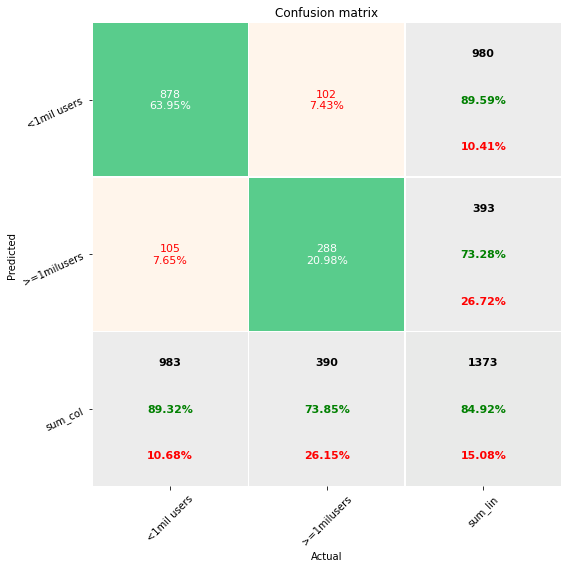

gradientboosting :


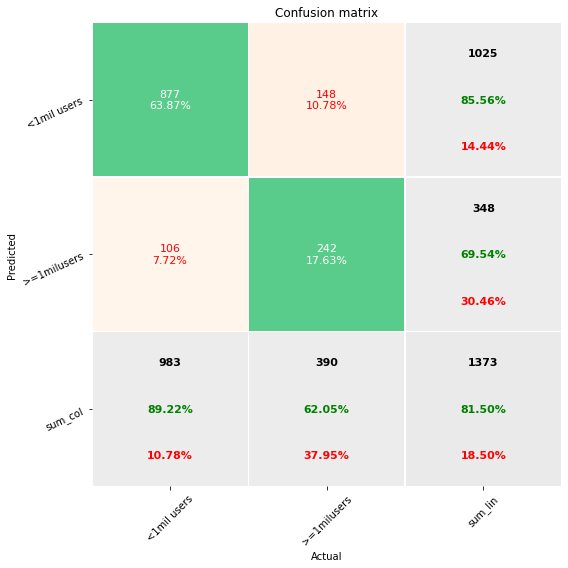

In [42]:
for name, model in fitted_models_f1.items():
    if name in ['logisticregression','gradientboosting']:
        pred = model.predict(X_test)
        print(name,':')
        plot_confusion_matrix_from_data(y_test,pred,columns=['<1mil users', '>=1milusers'], cmap='Oranges')

## Cross Validation & Hyper Tuning Parameters
Now that we have moved on to tuning modeling, we will use cross validation to help evaluate our k-fold. Since a lot of models constantly show signs of overfitting cross validation will help combat our overfit data. Our data will be partitioned into a limited sample in order to estimate how the model is expected to perform. 

We can also use the parameters given from the pipeline models.

In [43]:
def model_cross_val(model, cv):
    xgb = XGBClassifier()
    dtc = DecisionTreeClassifier()
    logreg = LogisticRegression(fit_intercept = False)
    tfc = RandomForestClassifier()
    gbc = GradientBoostingClassifier()
    
    accuracy = cross_val_score(model, X_trainres, y_trainres, scoring='f1', cv = cv)
    # get the mean of each fold 
    print(f'Accuracy of {model} with Cross Validation is:',accuracy.mean() * 100)
    return

In [44]:
def tuned_metrics(model):
    """ Show predictions and model results for hypertuned models """
    # Get predictions
    y_pred_train = model.predict(X_trainres)
    y_pred_test = model.predict(X_test)
    
    # Get classification report
    target_names =  ['< 1mil users', '>=1milusers']
    print(f'              Classification Report for Training Set')
    print(classification_report(y_trainres, y_pred_train, target_names = target_names))
    print(f'              Classification Report for Test Set ')
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    # Plot confusion Matrix
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
    plot_confusion_matrix(model, X_trainres, y_trainres,
                     cmap=plt.cm.Blues, ax=ax0, 
                      display_labels = target_names, normalize = 'all')
    plot_confusion_matrix(model, X_test, y_test,
                     cmap=plt.cm.Blues, ax=ax1,
                     display_labels = target_names, normalize = 'all')

    ax0.set(title = f'Train Confusion Matrix')
    ax1.set(title = f'Test Confusion Matrix')
    ax0.grid(False)
    ax1.grid(False)
    plt.show()
    
    return model

In [45]:
#Source: https://github.com/flatiron-school/ds-classification_workflow_demo-opw32/blob/vg-042621/classification_workflow.ipynb

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_neg_log_loss = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring="neg_log_loss")
        self.cv_log_loss = -(self.cv_neg_log_loss.mean())
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
            {self.cv_log_loss:.5f} log loss
        ''')
        print(cv_summary)

    
    def print_classification_metrics(self, y_pred):
        classification_metrics_summary = (
        f'''{classification_report(self.y, y_pred)}
            Accuracy Score = {self.model.score(self.X, self.y):.5f}
            Log Loss = {self.cv_log_loss:.5f}
        ''')
        print(classification_metrics_summary)
        f1 = self.model.score(self.X, self.y)
        
        return round(f1,5)
    
    def plot_cm(self, fig, title):
        '''
        Plot the confusion matrix values given figure and title.
        '''
        fig.suptitle(title)
        
        fig = plot_confusion_matrix(self.model, self.X, self.y, ax=ax, display_labels=['< 1mil users', '>=1milusers'], cmap=plt.cm.Blues);
        
        return fig

## Tuning Gradient Boosting with Cross Validation

In [46]:
gb_model = GradientBoostingClassifier()
model_cross_val(gb_model, 10)

Accuracy of GradientBoostingClassifier() with Cross Validation is: 91.15077184638719


In [47]:
gb_model = GradientBoostingClassifier()

param_grid = {'n_estimators': [150,200, 250],
              'learning_rate': [0.001, 0.01, 0.1, 1, 10],
              'max_depth': [4],
              'random_state': [42]}

gb_gs = GridSearchCV(gb_model, param_grid, cv=10)
gb_gs.fit(X_trainres, y_trainres)

gb_gs.best_params_

{'learning_rate': 1, 'max_depth': 4, 'n_estimators': 250, 'random_state': 42}

In [48]:
gb_gs.best_estimator_

GradientBoostingClassifier(learning_rate=1, max_depth=4, n_estimators=250,
                           random_state=42)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       983
           1       0.90      0.83      0.86       390

    accuracy                           0.92      1373
   macro avg       0.92      0.90      0.91      1373
weighted avg       0.92      0.92      0.92      1373

            Accuracy Score = 0.92498
            Log Loss = 0.97153
        


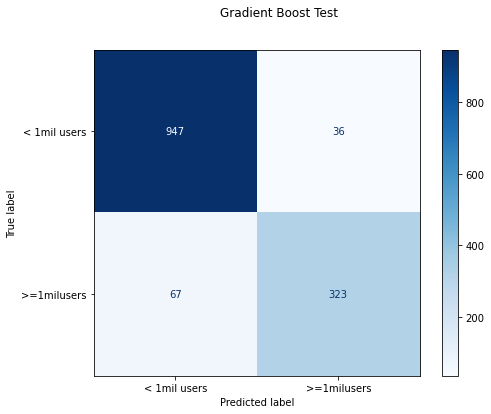

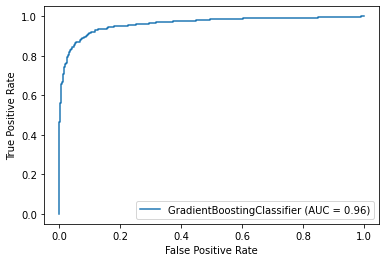

In [49]:
gs_gb_model = gb_gs.best_estimator_

gs_gb_model.fit(X_trainres, y_trainres)

gs_gb_model_train_results = ModelWithCV(model=gs_gb_model,
                                         model_name='gb',
                                         X=X_trainres,
                                         y=y_trainres)

gs_gb_model_test_results = ModelWithCV(model=gs_gb_model,
                                         model_name='gb',
                                         X=X_test,
                                         y=y_test)

fig, ax = plt.subplots(figsize=(8,6))

gs_gb_model_test_results.plot_cm(fig, title="Gradient Boost Test")

display(plot_roc_curve(gs_gb_model, X_test, y_test))

y_pred = gs_gb_model.predict(X_test)

gs_gb_model = gs_gb_model_test_results.print_classification_metrics(y_pred)

## XGBoost

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       983
           1       0.89      0.85      0.87       390

    accuracy                           0.93      1373
   macro avg       0.91      0.90      0.91      1373
weighted avg       0.93      0.93      0.93      1373

            Accuracy Score = 0.92571
            Log Loss = 0.25640
        


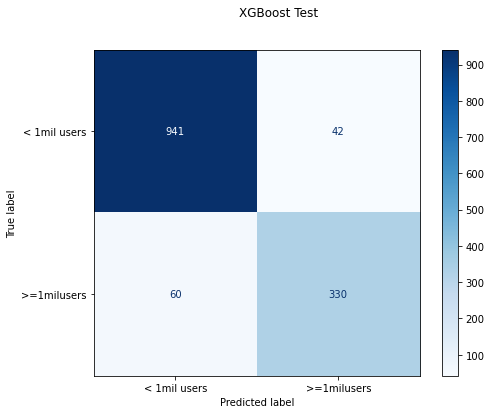

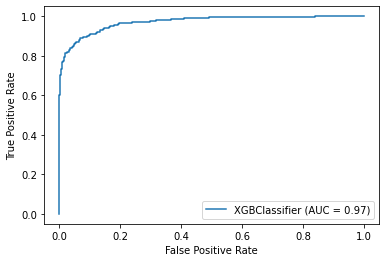

In [50]:
# XGBoost without tuning
xgb_model = XGBClassifier()

xgb_model.fit(X_trainres, y_trainres)

xgb_model_train_results = ModelWithCV(model=xgb_model,
                                         model_name='final_model',
                                         X=X_trainres,
                                         y=y_trainres)

xgb_model_test_results = ModelWithCV(model=xgb_model,
                                         model_name='final_model',
                                         X=X_test,
                                         y=y_test)
                                        
                                        
fig, ax = plt.subplots(figsize=(8,6))

display(xgb_model_test_results.plot_cm(fig, title="XGBoost Test"))

display(plot_roc_curve(xgb_model, X_test, y_test))

y_pred = xgb_model.predict(X_test)

final_model = xgb_model_test_results.print_classification_metrics(y_pred)

## Tuned XGBoost

In [51]:
xgb_model = XGBClassifier()

param_grid = {'n_estimators': [150,200, 250],
              'learning_rate': [0.001, 0.01, 0.1, 1, 10],
              'max_depth': [4],
              'objective': ['binary:logistic'],
              'booster': ['gbtree'],
              'tree_method': ['exact'],
              'random_state': [42]}

xgb_gs = GridSearchCV(xgb_model, param_grid, cv=10)
xgb_gs.fit(X_trainres, y_trainres)

xgb_gs.best_params_

{'booster': 'gbtree',
 'learning_rate': 1,
 'max_depth': 4,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'random_state': 42,
 'tree_method': 'exact'}

In [52]:
xgb_gs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       983
           1       0.87      0.85      0.86       390

    accuracy                           0.92      1373
   macro avg       0.91      0.90      0.90      1373
weighted avg       0.92      0.92      0.92      1373

            Accuracy Score = 0.92061
            Log Loss = nan
        


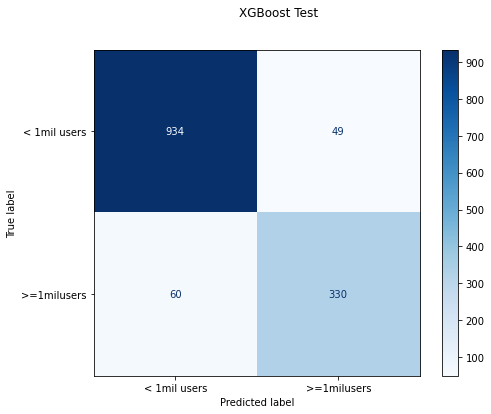

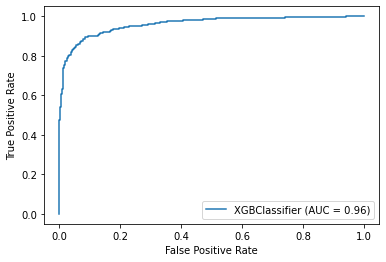

In [53]:
gs_xgb_model = xgb_gs.best_estimator_

gs_xgb_model.fit(X_trainres, y_trainres)

gs_xgb_model_train_results = ModelWithCV(model=gs_xgb_model,
                                         model_name='xgb_gs',
                                         X=X_trainres,
                                         y=y_trainres)

gs_xgb_model_test_results = ModelWithCV(model=gs_xgb_model,
                                         model_name='xgb_gs',
                                         X=X_test,
                                         y=y_test)

fig, ax = plt.subplots(figsize=(8,6))

display(gs_xgb_model_test_results.plot_cm(fig, title="XGBoost Test"))

display(plot_roc_curve(gs_xgb_model, X_test, y_test))

y_pred = gs_xgb_model.predict(X_test)

gs_xgb_model = gs_xgb_model_test_results.print_classification_metrics(y_pred)

## Feature Selection with Final Model

Since our models performed higher than they should and resulted in overfitting our next step is to use feature selection to reduce the number of features. This way we can use the features that is effectively capable of prediction. For feature selection we will be utilizing Recursive Feature Elimination wich elimiates the least important feature by recursively training.

In [54]:
# #Selecting the Best important features according to XGBoost
rfe_selector = RFE(estimator=XGBClassifier())
rfe_selector.fit(X_trainres, y_trainres)
X_trainres.columns[rfe_selector.get_support()]
dict(zip(X_trainres.columns, rfe_selector.get_support()))

{'discount': True,
 'release_year': True,
 'rating': True,
 'max_revenue': True,
 'Singleplayer': True,
 'Indie': True,
 'Steam_Achievements': True,
 'Action': True,
 'Adventure': True,
 'Steam_Trading_Cards': True,
 'Multiplayer': True,
 'Steam_Cloud': True,
 'Casual': True,
 'Strategy': True,
 'RPG': True,
 'Full_controller_support': True,
 'Atmospheric': True,
 'Simulation': True,
 'Coop': True,
 '2D': True,
 'Great_Soundtrack': False,
 'Story_Rich': True,
 'Open_World': True,
 'FirstPerson': True,
 'Shooter': True,
 'Funny': True,
 'Puzzle': True,
 'Partial_Controller_Support': True,
 'Fantasy': True,
 'Horror': True,
 'Scifi': True,
 'Difficult': True,
 'FPS': True,
 'Steam_Leaderboards': True,
 'Survival': True,
 'Third_Person': True,
 'Early_Access': True,
 'Exploration': True,
 'Sandbox': True,
 'Pixel_Graphics': False,
 'Online_MultiPlayer': True,
 'Anime': True,
 'PvP': True,
 'Female_Protagonist': True,
 'Online_CoOp': True,
 'Online_Coop': True,
 'Gore': True,
 'Comedy': Tr

In [55]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [56]:
X_train_selected = select_important_features(X=X_trainres, selector=rfe_selector)
X_train_selected.shape

(5898, 133)

In [57]:
XGB_sel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGB_sel.fit(X_train_selected, y_trainres)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
def plot_feat_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(20)
    feat_importances.plot(kind='barh', title='Top 20 Important Features',legend=False, figsize=(10,10))
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

##  XGBoost Model Feature Importance

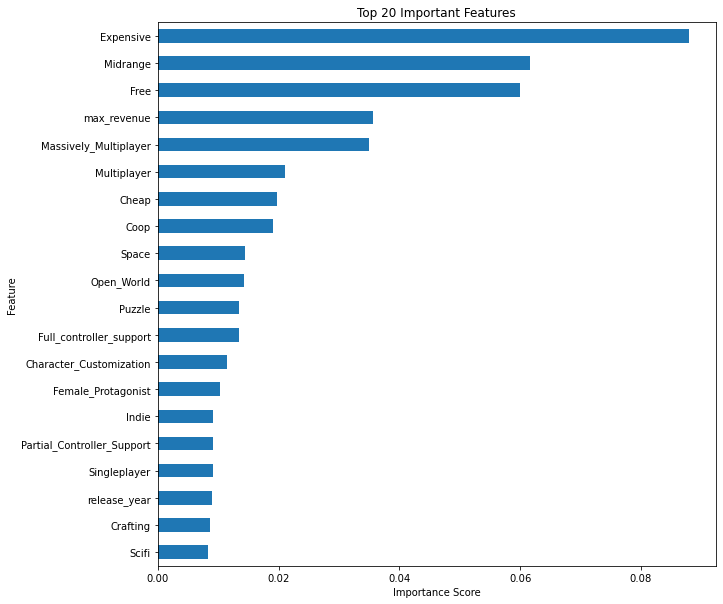

In [59]:
clf = xgb_model
clf.fit(X_trainres, y_trainres)
plot_feat_importance(clf, X_trainres.columns)

## Tuned XGBoost Feature Importance

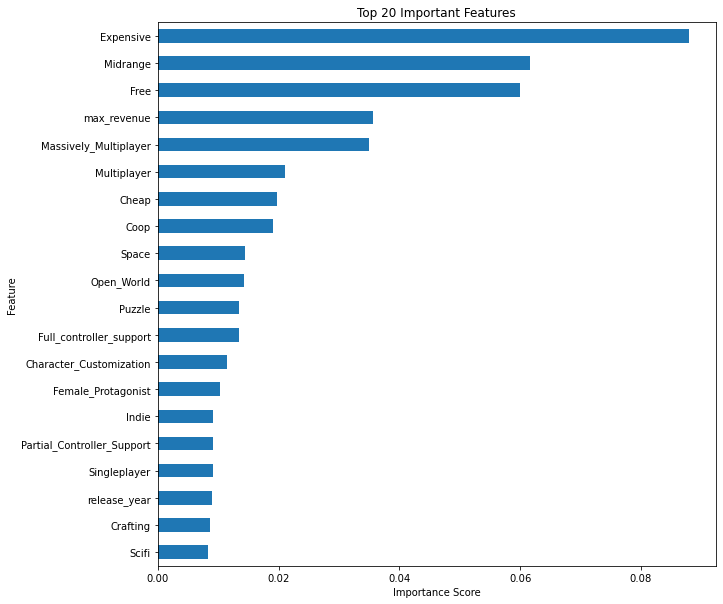

In [60]:
clf = xgb_model
clf.fit(X_trainres, y_trainres)
plot_feat_importance(clf, X_trainres.columns)

## Tuned Gradient Boosting Feature Importance

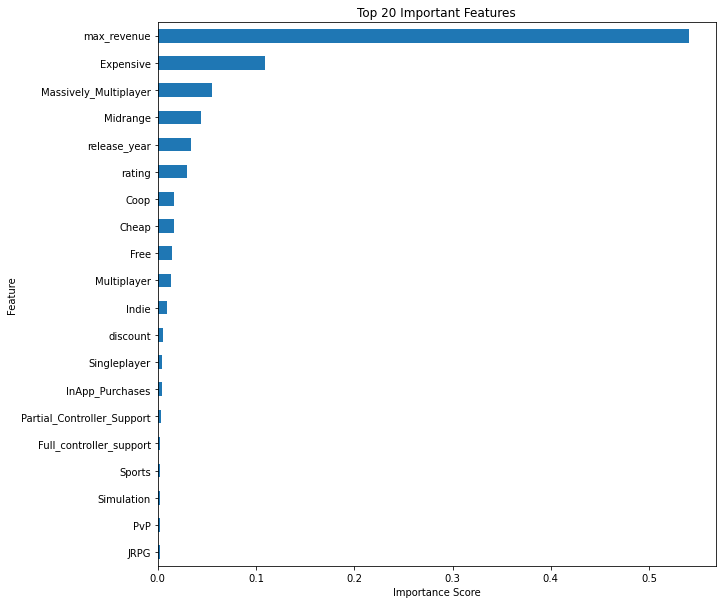

In [62]:
clf = gb_gs.best_estimator_
clf.fit(X_trainres, y_trainres)
plot_feat_importance(clf, X_trainres.columns)

## Tuned XGBoost Model with Feature Selection

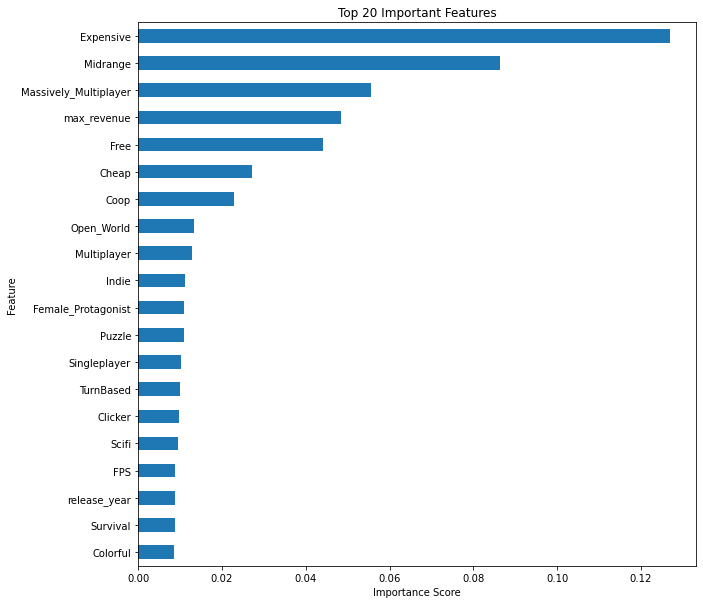

In [63]:
clf = XGB_sel
clf.fit(X_train_selected, y_trainres)
plot_feat_importance(clf, X_train_selected.columns)

In [64]:
print('      Simple Baseline Model Results     ')
print(results1.sort_values('f1',ascending=False))
print('=========================================')
print('  Simple Bassline Model Results Scaled  ')
print(results2.sort_values('f1',ascending=False))
print('=========================================')
print('  Simple Bassline Model Results SMOTENC  ')
print(results3.sort_values('f1',ascending=False))

      Simple Baseline Model Results     
                          f1   roc_auc  accuracy  precision    recall
KNN                 0.849398  0.873516  0.927167   0.969072  0.756032
Gradient Boosting   0.843478  0.877080  0.921340   0.917981  0.780161
DecisionTree        0.834455  0.885550  0.910415   0.837838  0.831099
RandomForest        0.767584  0.821461  0.889294   0.893238  0.672922
LogisticRegression  0.629758  0.732468  0.844137   0.887805  0.487936
  Simple Bassline Model Results Scaled  
                          f1   roc_auc  accuracy  precision    recall
DecisionTree        0.862385  0.899414  0.923525   0.882038  0.843590
Gradient Boosting   0.853147  0.880853  0.923525   0.938462  0.782051
LogisticRegression  0.777465  0.831466  0.884924   0.862500  0.707692
RandomForest        0.742681  0.799819  0.878369   0.930502  0.617949
KNN                 0.476534  0.652954  0.788784   0.804878  0.338462
  Simple Bassline Model Results SMOTENC  
                          f1   roc_a

## Conclusions

Many of our models performed extremely well on their training data but scored poorly on the testing set. You can see a difference in scores for Decision Tree and Random Forest with a testing set f1-score of .83 and .77 respectively. Models that follow this pattern exhibit signs of overfitting. In order to prevent our models from creating bias we need to perform scaling and SMOTE to correct for the imbalance targets. After scaling our data we were able to improve our f1 scores for Decision Tree, Gradient Boosting, Random Forest, and Logistic Regression. Our KNN Model f1 score dropped by 53%. Our third tweaking for our baseline models is using SMOTENC on the numerical features to combat the class imbalance.


Based on the results of our models our final model that we will pick to make our final suggestion is our Cross Validated XGBoost Model. It scored the highest f1 score and area under curve. The reason I chose f1 as our metric because I am looking for the what percent of the positive predictoins were correct. Meaning that our CV XGBoost model was able to predict 87% of games that have a high usercount of over 1mil. The area under the curve score is our indicator to see how well the model was able to distinguish between classes. With our results our model was able to decipher 97% between the positive and negative classes. Although our Models performed relatively there was very obvious signs of overfitting. It could be from having many categorical features.

# Recommendations

With these feature importance we suggest developers and publishers:
- Release a Massively Multiplayer game or MMOs like WoW or currently a very popular game right now Lost Ark so players have the opportunity to play with their friends which leds to higher usercount. 
- Other features to include is a game with the setting in space that is open world for players to explore on their own time with challenging puzzle games. A game that is out of this world ! (Literally)


So a game that is a mixture of Among Us, Breath of the Wild with some Tetris that we are all able to play with. 

# Future Work

- Use different targets to predict popular Steam Games
- Game Review Sentiment Analysis
- Linear Regression on Game Revenue
- NLP System Requirements

In [ ]:
## Future work

# Creating function for cleaning, tokenize and lemmatization.
# def cleaning(data):
#     """ This function cleans each word from punctuations, lowers each character, removes stopwords and 
#     lemmatization for each word."""
    
#     #Tokenize
#     text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
#     #Remove punctuations
#     tokens_without_punc = [w for w in text_tokens if w.isalpha()] 
    
#     #Removing Stopwords
#     tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]  
    
#     #lemma
#     text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
#     #joining
#     return " ".join(text_cleaned)

In [ ]:
## detailed description

# df2 = df.copy()
# text_df = df2.select_dtypes('object', 'category')
# text_df['detailed_description'] = text_df['detailed_description'].str.replace("(@+\w+)", "")
# text_df['detailed_description'].head()

# total_vocabulary = []
# for desc in text_df['detailed_description'].tolist():
#     total_vocabulary += desc.split()
# freqdist = FreqDist(total_vocabulary)
# top_50 = freqdist.most_common(50)

In [ ]:
# Creating variable for english stopwords.
# list1 = ['br', 'ul', 'img','http', 'p', 'target=_blank', 'has', 'one', 'out', '<br', 'http', ]
# stop_words = stopwords.words('english') + list1
# stop_words

In [ ]:
# text_df['detailed_description'] = text_df['detailed_description'].apply(cleaning)
# text_df['detailed_description'].head()
#' '.join(text_df['detailed_description']).split()

In [ ]:
# Counting most common words.
# corpus = " ".join(text_df['detailed_description'])
# tokens_count = Counter(word_tokenize(corpus)).most_common(20)
# tokens_count

In [ ]:
# Visual of most common words.
# dic= dict(tokens_count)
# fig, ax = plt.subplots(figsize=(16,6))
# ax.bar(dic.keys(),dic.values())
# ax.set_title('Most Common Words',fontsize=18)
# plt.xlabel('Words',fontsize=14)
# plt.ylabel('Count',fontsize=14)
# ax = plt.gca()
# ax.tick_params(labelsize = 14)
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# importing CountVectorizer from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# creating vectoriser with english stopwords 
stop_words = CountVectorizer(stop_words='english')

In [ ]:
# df['game_attributes'] = df['game_attributes'].str.replace(';', ',').str.replace('-','').str.replace(', ', ',').str.replace(' ,', ',').str.replace('-','').str.replace(' ','_')

In [ ]:
# # Preprocess
# ​
# # Scale your data
# # explain
# X_scaler = StandardScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# ​
# # Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)
# ​
# # Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)
# 3
# #Train the model
# ​
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# ​
# # Create model and add layers
# model = Sequential()
# model.add(Dense(units=100, activation='relu', input_dim=463))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=2, activation='sigmoid'))
# # Compile and fit the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# ​
# model.summary()

# model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     epochs=40)

# # Quantify the model
# model_loss, model_accuracy = model.evaluate(
#     X_test_scaled, y_test_categorical, verbose=2)
# print(
#     f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")
# 43/43 - 0s - loss: 2.3374 - accuracy: 0.6424
# Normal Neural Network - Loss: 2.337416648864746, Accuracy: 0.6423889398574829
# #Predictions
# encoded_predictions = model.predict_classes(X_test_scaled[:5])
# prediction_labels = label_encoder.inverse_transform(encoded_predictions)
# print(f"Predicted classes: {prediction_labels}")
# print(f"Actual Labels: {list(y_test[:5])}")

## Text Cleaning & Preprocessing

- The goal is to text clean and preprocess game attributes

## Count Vectorizer

In [ ]:
# from nltk import FreqDist
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.probability import FreqDist
# from nltk.tokenize import RegexpTokenizer
# from sklearn.feature_extraction.text import CountVectorizer
# from collections import Counter
# import string
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('words')

In [ ]:
# # importing CountVectorizer from sklearn
# from sklearn.feature_extraction.text import CountVectorizer

# # creating vectoriser with english stopwords 
# stop_words = CountVectorizer(stop_words='english')

In [ ]:
# def count_vectorizer(name):
#     count_vec=CountVectorizer()
#     encoded=count_vec.fit_transform(name)
#     encoded= pd.DataFrame(encoded.toarray(), columns=count_vec.vocabulary_)
#     return encoded

In [ ]:
# df['game_attributes'] = df['game_attributes'].str.replace(';', ',').str.replace('-','').str.replace(', ', ',').str.replace(' ,', ',').str.replace('-','').str.replace(' ','_')
# game_att = count_vectorizer(df['game_attributes'])
# game_att_sum = game_att.sum(axis=1)
# game_att = game_att[game_att_sum > 0].copy()
# game_att

In [ ]:
# model_df = df.merge(game_att, left_index = True, right_index = True, how = 'inner')